# 05_backbone_comparison.ipynb

In [1]:
# Frozen vs Unfrozen backbone comparison

# Import libraries
import os
import json
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models, transforms
from PIL import Image

In [2]:
# Paths
DATASET_DIR = "../data/raw/EuroSAT_RGB"
OUTPUT_DIR = "../data/processed"
MODEL_DIR = "../models"
RESULTS_DIR = "../results"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

In [3]:
# Set random seeds for reproducibility
SEED = 1
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

In [4]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
# Dataset and Dataloader setup
class EuroSATDataset(Dataset):
    """
    Dataset class for EuroSAT dataset
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        
        # Load all image paths and labels
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for img_name in os.listdir(class_dir):
                if img_name.endswith('.jpg'):
                    self.images.append(os.path.join(class_dir, img_name))
                    self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [6]:
class TransformedSubset(Dataset):
    """
    Dataset wrapper that applies transforms to a subset
    """
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.subset)

In [8]:
# Load data splits or create them if not available
def get_data_loaders(batch_size=32, num_workers=0): # set num_workers > 0 for parallel data loading
    """
    Prepare datasets and dataloaders
    
    Args:
        batch_size: Batch size for training
        num_workers: Number of workers for data loading
        
    Returns:
        train_loader, val_loader, test_loader, class_to_idx, idx_to_class
    """
    # Define transformations
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
    ])

    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
    ])
    
    # Try loading existing splits
    splits_path = os.path.join(OUTPUT_DIR, 'dataset_splits.pt')
    
    if os.path.exists(splits_path):
        print("Loading existing dataset splits...")
        full_dataset = EuroSATDataset(DATASET_DIR, transform=None)
        class_to_idx = full_dataset.class_to_idx
        idx_to_class = {i: name for name, i in class_to_idx.items()}
        
        # Load dataset splits
        splits = torch.load(splits_path)
        train_indices = splits['train_indices']
        val_indices = splits['val_indices']
        test_indices = splits['test_indices']
        
        # Create subsets
        train_dataset = Subset(full_dataset, train_indices)
        val_dataset = Subset(full_dataset, val_indices)
        test_dataset = Subset(full_dataset, test_indices)
        
    else:
        print("Creating new dataset splits...")
        # Create full dataset
        full_dataset = EuroSATDataset(DATASET_DIR, transform=None)
        class_to_idx = full_dataset.class_to_idx
        idx_to_class = {i: name for name, i in class_to_idx.items()}
        
        # Split dataset into train, validation, and test sets
        total_size = len(full_dataset)
        train_size = int(0.7 * total_size)
        val_size = int(0.15 * total_size)
        test_size = total_size - (train_size + val_size)
        
        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
            full_dataset, [train_size, val_size, test_size], 
            generator=torch.Generator().manual_seed(SEED)
        )
        
        # Save dataset splits
        torch.save({
            'train_indices': train_dataset.indices,
            'val_indices': val_dataset.indices,
            'test_indices': test_dataset.indices,
        }, splits_path)
        
        # Save class mappings
        with open(os.path.join(OUTPUT_DIR, "class_mappings.json"), "w") as f:
            json.dump({"class_to_idx": class_to_idx, "idx_to_class": idx_to_class}, f)
    
    # Apply transformations to datasets
    train_dataset = TransformedSubset(train_dataset, train_transform)
    val_dataset = TransformedSubset(val_dataset, val_transform)
    test_dataset = TransformedSubset(test_dataset, val_transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    print(f"Dataset loaded with {len(train_dataset)} training, {len(val_dataset)} validation, and {len(test_dataset)} test images")
    
    return train_loader, val_loader, test_loader, class_to_idx, idx_to_class

In [15]:
# Model creation function
def create_model(model_name='resnet50', num_classes=10, freeze_backbone=True):
    """
    Create a model with a pretrained backbone
    
    Args:
        model_name: Name of the model to use
        num_classes: Number of output classes
        freeze_backbone: Whether to freeze the backbone weights
        
    Returns:
        model: PyTorch model
    """
    # Load pretrained model
    if model_name == 'resnet18':
        model = models.resnet18(weights='IMAGENET1K_V1')
    elif model_name == 'resnet50':
        model = models.resnet50(weights='IMAGENET1K_V1')
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights='IMAGENET1K_V1')
    elif model_name == 'efficientnet_b4':
        model = models.efficientnet_b4(weights='IMAGENET1K_V1')
    else:
        raise ValueError(f"Model {model_name} not supported")
    
    # Freeze backbone if specified
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
    
    # Replace the last fully connected layer
    if model_name.startswith('resnet'):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name.startswith('efficientnet'):
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    return model

In [18]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=25, patience=8, min_delta=0.0005):
    """
    Train a model with early stopping
    
    Args:
        model: PyTorch model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler (optional)
        num_epochs: Maximum number of epochs to train for
        patience: Number of epochs to wait for improvement before early stopping
        
    Returns:
        model: Trained model
        history: Training history dictionary
    """
    model = model.to(device)
    
    # Initialize training metrics
    best_model_wts = model.state_dict()
    best_acc = 0.0
    epochs_no_improve = 0
    early_stopped = False
    
    # For tracking metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    # Memory usage tracking
    if torch.cuda.is_available():
        peak_memory_start = torch.cuda.max_memory_allocated() / (1024 ** 2)
        print(f"Initial GPU memory usage: {peak_memory_start:.2f} MB")
    
    # Time tracking
    start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            progress_bar = tqdm(dataloader, desc=f"{phase.capitalize()} Batch")
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Stats
                batch_loss = loss.item() * inputs.size(0)
                batch_corrects = torch.sum(preds == labels.data).item()
                batch_accuracy = batch_corrects / inputs.size(0)
                
                running_loss += batch_loss
                running_corrects += batch_corrects
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': batch_loss / inputs.size(0),
                    'acc': batch_accuracy
                })
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects / len(dataloader.dataset)
            
            # Store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
                if scheduler and scheduler.__class__.__name__ != 'ReduceLROnPlateau':
                    scheduler.step()
            else:  # val
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                
                # If scheduler is ReduceLROnPlateau, step based on validation loss
                if scheduler and scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    scheduler.step(epoch_loss)
                
                # Deep copy the model if best validation accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict().copy()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Early stopping check
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            early_stopped = True
            break
        
        print()  # Empty line between epochs
    
    # Calculate training time
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation accuracy: {best_acc:.4f}')
    
    # Memory usage reporting
    if torch.cuda.is_available():
        peak_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)
        print(f"Peak GPU memory usage: {peak_memory:.2f} MB")
    
    # Add early stopping info to history
    history['early_stopped'] = early_stopped
    history['epochs_completed'] = epoch + 1
    history['best_val_acc'] = best_acc
    history['training_time'] = time_elapsed
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [19]:
# Evaluation function
def evaluate_model(model, test_loader, class_names):
    """
    Evaluate a trained model on the test set
    
    Args:
        model: Trained PyTorch model
        test_loader: DataLoader for test data
        class_names: List of class names
        
    Returns:
        test_acc: Test accuracy
        y_true: True labels
        y_pred: Predicted labels
    """
    model.eval()
    
    y_true = []
    y_pred = []
    test_loss = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    # Calculate metrics
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = (np.array(y_true) == np.array(y_pred)).mean()
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    return test_acc, y_true, y_pred

In [20]:
# Save model function
def save_model(model, model_name, freeze_backbone, class_to_idx, history, test_acc):
    """
    Save a trained model with metadata
    
    Args:
        model: Trained PyTorch model
        model_name: Name of the model architecture
        freeze_backbone: Whether backbone was frozen during training
        class_to_idx: Class to index mapping
        history: Training history
        test_acc: Test accuracy
    
    Returns:
        save_path: Path where model was saved
    """
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    backbone_status = 'frozen' if freeze_backbone else 'unfrozen'
    save_path = os.path.join(MODEL_DIR, f"{model_name}_{backbone_status}_{timestamp}.pth")
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'class_to_idx': class_to_idx,
        'idx_to_class': {i: name for name, i in class_to_idx.items()},
        'model_name': model_name,
        'freeze_backbone': freeze_backbone,
        'history': history,
        'test_accuracy': test_acc,
        'timestamp': timestamp
    }
    
    torch.save(checkpoint, save_path)
    print(f"Model saved to {save_path}")
    return save_path

In [21]:
# Function to run experiment for a single model configuration
def run_experiment(model_name, freeze_backbone, train_loader, val_loader, test_loader, 
                class_to_idx, class_names, num_epochs=25, batch_size=32, learning_rate=0.005):
    """
    Train and evaluate a model with specified backbone freezing
    
    Args:
        model_name: Name of the model architecture
        freeze_backbone: Whether to freeze the backbone
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        test_loader: DataLoader for test data
        class_to_idx: Class to index mapping
        class_names: List of class names
        num_epochs: Number of epochs to train
        batch_size: Batch size
        learning_rate: Initial learning rate
        
    Returns:
        results: Dictionary containing experiment results
    """
    backbone_status = 'frozen' if freeze_backbone else 'unfrozen'
    print(f"{'='*20} Training {model_name} with {backbone_status} backbone {'='*20}")
    
    # Create model
    model = create_model(model_name, num_classes=len(class_to_idx), freeze_backbone=freeze_backbone)
    
    # Define loss function, optimizer, scheduler
    criterion = nn.CrossEntropyLoss()
    
    # When backbone is unfrozen, use a lower learning rate
    if not freeze_backbone:
        learning_rate = learning_rate / 10
    
    # Configure optimizer with appropriate parameters
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Use ReduceLROnPlateau scheduler for adaptive learning rate
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3, verbose=True
    )
    
    # Train model
    start_time = time.time()
    model, history = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience=5
    )
    time_elapsed = time.time() - start_time
    
    # Evaluate on test set
    test_acc, y_true, y_pred = evaluate_model(model, test_loader, class_names)
    
    # Save model
    save_path = save_model(model, model_name, freeze_backbone, class_to_idx, history, test_acc)
    
    # Collect and return results
    results = {
        'model_name': model_name,
        'freeze_backbone': freeze_backbone,
        'history': history,
        'test_accuracy': test_acc,
        'training_time': time_elapsed,
        'y_true': y_true,
        'y_pred': y_pred,
        'model_path': save_path
    }
    
    return results

In [ ]:
# Function to compare frozen vs unfrozen backbones
def compare_models(frozen_results, unfrozen_results):
    """
    Compare performance between frozen and unfrozen models
    
    Args:
        frozen_results: Results from frozen backbone experiment
        unfrozen_results: Results from unfrozen backbone experiment
    """
    model_name = frozen_results['model_name']
    timestamp = datetime.datetime.now().strftime("%Y%m%d")
    
    # Create comparison table
    comparison = {
        'Model': model_name,
        'Frozen Test Accuracy': frozen_results['test_accuracy'],
        'Unfrozen Test Accuracy': unfrozen_results['test_accuracy'],
        'Accuracy Difference': unfrozen_results['test_accuracy'] - frozen_results['test_accuracy'],
        'Frozen Training Time (m)': frozen_results['training_time'] // 60,
        'Unfrozen Training Time (m)': unfrozen_results['training_time'] // 60,
        'Training Time Ratio': unfrozen_results['training_time'] / frozen_results['training_time'],
        'Frozen Epochs': frozen_results['history']['epochs_completed'],
        'Unfrozen Epochs': unfrozen_results['history']['epochs_completed']
    }
    
    # Print comparison
    print("\n=== Model Performance Comparison ===")
    print(f"Model: {comparison['Model']}")
    print(f"Frozen Test Accuracy: {comparison['Frozen Test Accuracy']:.4f}")
    print(f"Unfrozen Test Accuracy: {comparison['Unfrozen Test Accuracy']:.4f}")
    print(f"Accuracy Difference: {comparison['Accuracy Difference']:.4f}")
    print(f"Frozen Training Time: {comparison['Frozen Training Time (m)']:.1f} minutes")
    print(f"Unfrozen Training Time: {comparison['Unfrozen Training Time (m)']:.1f} minutes")
    print(f"Training Time Ratio: {comparison['Training Time Ratio']:.2f}x")
    print(f"Frozen Epochs Completed: {comparison['Frozen Epochs']}")
    print(f"Unfrozen Epochs Completed: {comparison['Unfrozen Epochs']}")
    
    # Plot training history comparison
    plt.figure(figsize=(15, 10))
    
    # Plot training loss
    plt.subplot(2, 2, 1)
    plt.plot(frozen_results['history']['train_loss'], label='Frozen Backbone')
    plt.plot(unfrozen_results['history']['train_loss'], label='Unfrozen Backbone')
    plt.title(f'{model_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot validation loss
    plt.subplot(2, 2, 2)
    plt.plot(frozen_results['history']['val_loss'], label='Frozen Backbone')
    plt.plot(unfrozen_results['history']['val_loss'], label='Unfrozen Backbone')
    plt.title(f'{model_name} - Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training accuracy
    plt.subplot(2, 2, 3)
    plt.plot(frozen_results['history']['train_acc'], label='Frozen Backbone')
    plt.plot(unfrozen_results['history']['train_acc'], label='Unfrozen Backbone')
    plt.title(f'{model_name} - Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot validation accuracy
    plt.subplot(2, 2, 4)
    plt.plot(frozen_results['history']['val_acc'], label='Frozen Backbone')
    plt.plot(unfrozen_results['history']['val_acc'], label='Unfrozen Backbone')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f"{model_name}_{timestamp}_comparison.png"))
    plt.show()
    
    # Save comparison results
    comparison_path = os.path.join(RESULTS_DIR, f"{model_name}_{timestamp}_comparison.json")
    with open(comparison_path, 'w') as f:
        json.dump(comparison, f, indent=4)
    
    print(f"Comparison saved to {comparison_path}")

In [23]:
# Main execution function
def main():
    """Main function to run experiments"""
    # Configuration
    model_name = 'resnet50'  # Options: 'resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b4'
    num_epochs = 25
    batch_size = 32
    learning_rate = 0.005
    
    # Load data
    train_loader, val_loader, test_loader, class_to_idx, idx_to_class = get_data_loaders(batch_size=batch_size)
    class_names = [idx_to_class[i] for i in range(len(class_to_idx))]
    
    # Run frozen backbone experiment
    frozen_results = run_experiment(
        model_name=model_name,
        freeze_backbone=True,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        class_to_idx=class_to_idx,
        class_names=class_names,
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=learning_rate
    )
    
    # Run unfrozen backbone experiment
    unfrozen_results = run_experiment(
        model_name=model_name,
        freeze_backbone=False,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        class_to_idx=class_to_idx,
        class_names=class_names,
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=learning_rate
    )
    
    # Compare results
    compare_models(frozen_results, unfrozen_results)

Loading existing dataset splits...
Dataset loaded with 18900 training, 4050 validation, and 4050 test images
==================== Training resnet50 with frozen backbone ====================
Epoch 1/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.1890 Acc: 0.6968


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 1.4638 Acc: 0.7304

Epoch 2/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.1178 Acc: 0.7451


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 1.3274 Acc: 0.7625

Epoch 3/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.1588 Acc: 0.7587


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 1.4892 Acc: 0.7689

Epoch 4/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.1802 Acc: 0.7684


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.8638 Acc: 0.8262

Epoch 5/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.2210 Acc: 0.7667


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.9306 Acc: 0.8277

Epoch 6/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.2206 Acc: 0.7733


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 1.0008 Acc: 0.8254

Epoch 7/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.2213 Acc: 0.7740


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.9660 Acc: 0.8190

Epoch 8/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.2239 Acc: 0.7754


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.9867 Acc: 0.8240

Epoch 9/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.8497 Acc: 0.8230


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.6979 Acc: 0.8553

Epoch 10/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.7515 Acc: 0.8276


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.6913 Acc: 0.8501

Epoch 11/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.8340


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.6774 Acc: 0.8499

Epoch 12/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.6464 Acc: 0.8358


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.5862 Acc: 0.8556

Epoch 13/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.6206 Acc: 0.8384


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.6640 Acc: 0.8432

Epoch 14/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.5912 Acc: 0.8406


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.5310 Acc: 0.8615

Epoch 15/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.5887 Acc: 0.8385


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.6210 Acc: 0.8501

Epoch 16/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.5694 Acc: 0.8440


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.5515 Acc: 0.8602

Epoch 17/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.5495 Acc: 0.8444


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.5248 Acc: 0.8617

Epoch 18/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.5435 Acc: 0.8448


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.6020 Acc: 0.8489

Epoch 19/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.5324 Acc: 0.8424


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.5217 Acc: 0.8578

Epoch 20/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.5290 Acc: 0.8456


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.5140 Acc: 0.8620

Epoch 21/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.5254 Acc: 0.8457


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.4755 Acc: 0.8672

Epoch 22/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.5114 Acc: 0.8465


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.4114 Acc: 0.8805

Epoch 23/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.5173 Acc: 0.8479


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.4793 Acc: 0.8635

Epoch 24/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.5014 Acc: 0.8461


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.4381 Acc: 0.8758

Epoch 25/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.5037 Acc: 0.8463


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.5956 Acc: 0.8506

Training complete in 62m 28s
Best validation accuracy: 0.8805


Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Test Loss: 0.6179
Test Accuracy: 0.8370


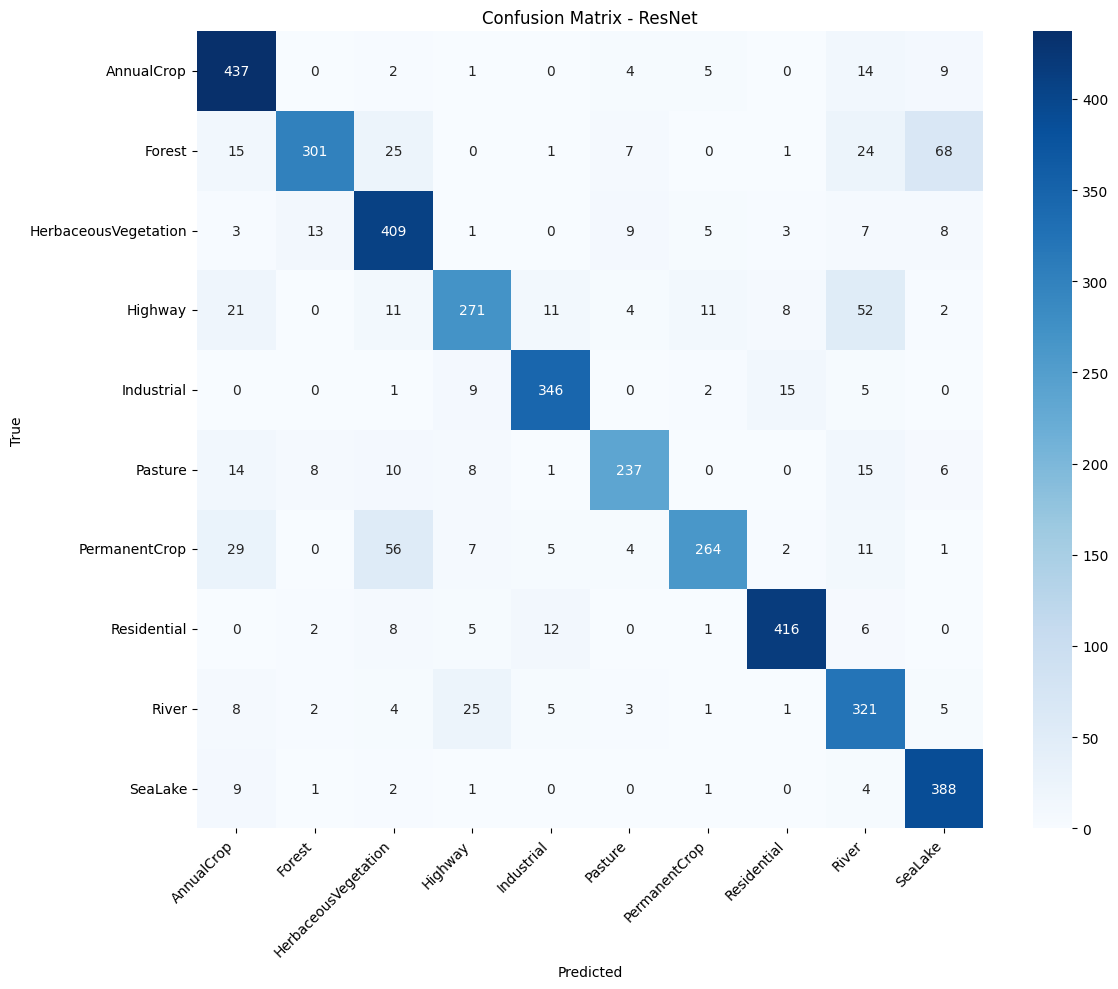

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.82      0.93      0.87       472
              Forest       0.92      0.68      0.78       442
HerbaceousVegetation       0.77      0.89      0.83       458
             Highway       0.83      0.69      0.75       391
          Industrial       0.91      0.92      0.91       378
             Pasture       0.88      0.79      0.84       299
       PermanentCrop       0.91      0.70      0.79       379
         Residential       0.93      0.92      0.93       450
               River       0.70      0.86      0.77       375
             SeaLake       0.80      0.96      0.87       406

            accuracy                           0.84      4050
           macro avg       0.85      0.83      0.83      4050
        weighted avg       0.85      0.84      0.84      4050

Model saved to ../models\resnet50_frozen_20250409_1821.pth
==================== Training resnet50 with unf

Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.5181 Acc: 0.8410


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.2169 Acc: 0.9309

Epoch 2/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.3252 Acc: 0.8950


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1937 Acc: 0.9341

Epoch 3/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.2755 Acc: 0.9069


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1914 Acc: 0.9356

Epoch 4/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.2619 Acc: 0.9135


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1546 Acc: 0.9501

Epoch 5/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1956 Acc: 0.9341


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1611 Acc: 0.9444

Epoch 6/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1836 Acc: 0.9372


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1434 Acc: 0.9528

Epoch 7/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1770 Acc: 0.9403


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.2676 Acc: 0.9121

Epoch 8/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1729 Acc: 0.9401


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1580 Acc: 0.9481

Epoch 9/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1644 Acc: 0.9442


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1354 Acc: 0.9526

Epoch 10/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1528 Acc: 0.9490


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1235 Acc: 0.9588

Epoch 11/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1469 Acc: 0.9497


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1190 Acc: 0.9612

Epoch 12/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1450 Acc: 0.9508


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1372 Acc: 0.9543

Epoch 13/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1367 Acc: 0.9515


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.2081 Acc: 0.9323

Epoch 14/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1295 Acc: 0.9548


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1652 Acc: 0.9481

Epoch 15/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1283 Acc: 0.9560


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1045 Acc: 0.9644

Epoch 16/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1188 Acc: 0.9601


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1098 Acc: 0.9654

Epoch 17/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1159 Acc: 0.9604


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.0901 Acc: 0.9689

Epoch 18/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1093 Acc: 0.9613


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1158 Acc: 0.9632

Epoch 19/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1134 Acc: 0.9623


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1445 Acc: 0.9506

Epoch 20/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1106 Acc: 0.9625


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1151 Acc: 0.9590

Epoch 21/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.0970 Acc: 0.9664


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1425 Acc: 0.9568

Epoch 22/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.0603 Acc: 0.9792


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.0788 Acc: 0.9743

Epoch 23/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.0403 Acc: 0.9861


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.0761 Acc: 0.9746

Epoch 24/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.0365 Acc: 0.9872


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.0751 Acc: 0.9738

Epoch 25/25
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.0322 Acc: 0.9898


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.0715 Acc: 0.9768

Training complete in 158m 29s
Best validation accuracy: 0.9768


Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Test Loss: 0.0817
Test Accuracy: 0.9753


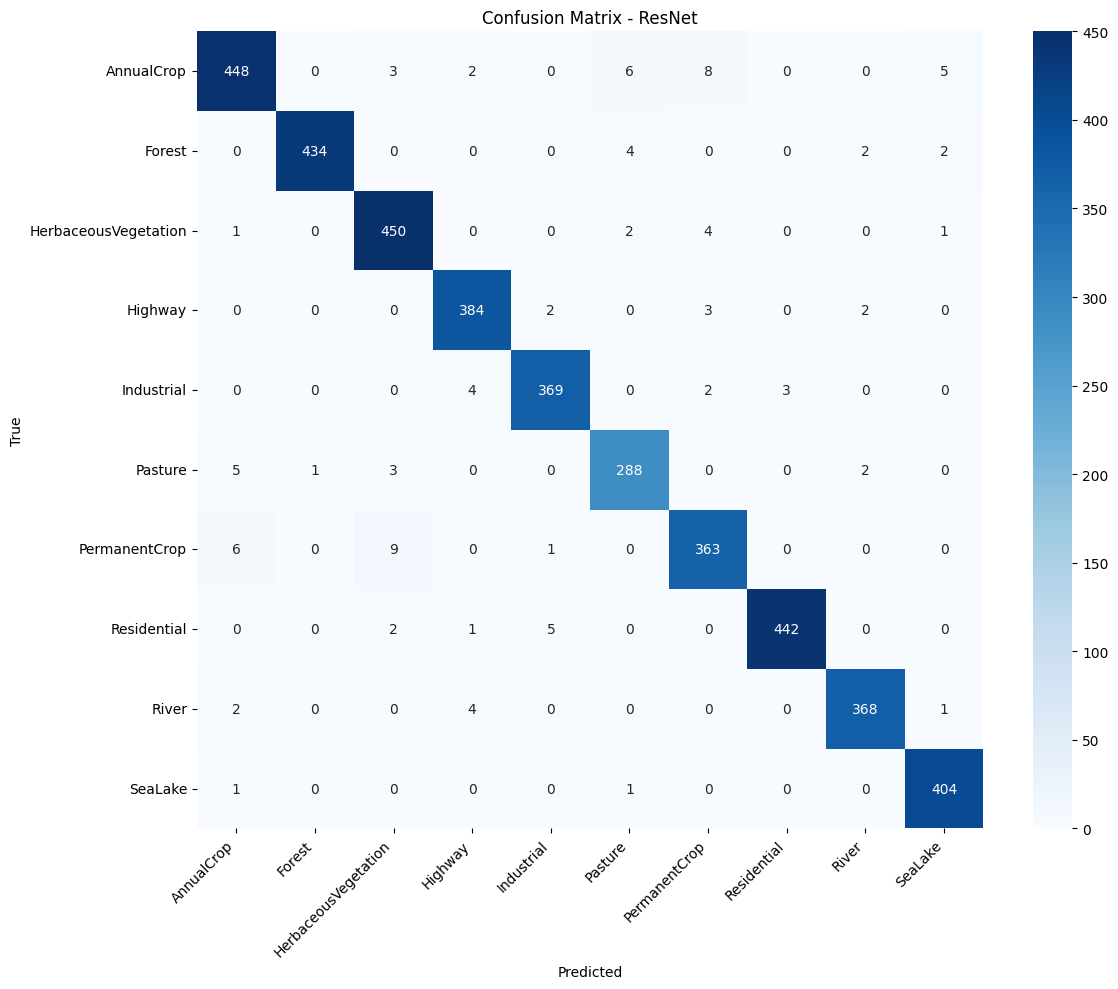

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.97      0.95      0.96       472
              Forest       1.00      0.98      0.99       442
HerbaceousVegetation       0.96      0.98      0.97       458
             Highway       0.97      0.98      0.98       391
          Industrial       0.98      0.98      0.98       378
             Pasture       0.96      0.96      0.96       299
       PermanentCrop       0.96      0.96      0.96       379
         Residential       0.99      0.98      0.99       450
               River       0.98      0.98      0.98       375
             SeaLake       0.98      1.00      0.99       406

            accuracy                           0.98      4050
           macro avg       0.97      0.98      0.97      4050
        weighted avg       0.98      0.98      0.98      4050

Model saved to ../models\resnet50_unfrozen_20250409_2059.pth

=== Model Performance Comparison ===
Model: 

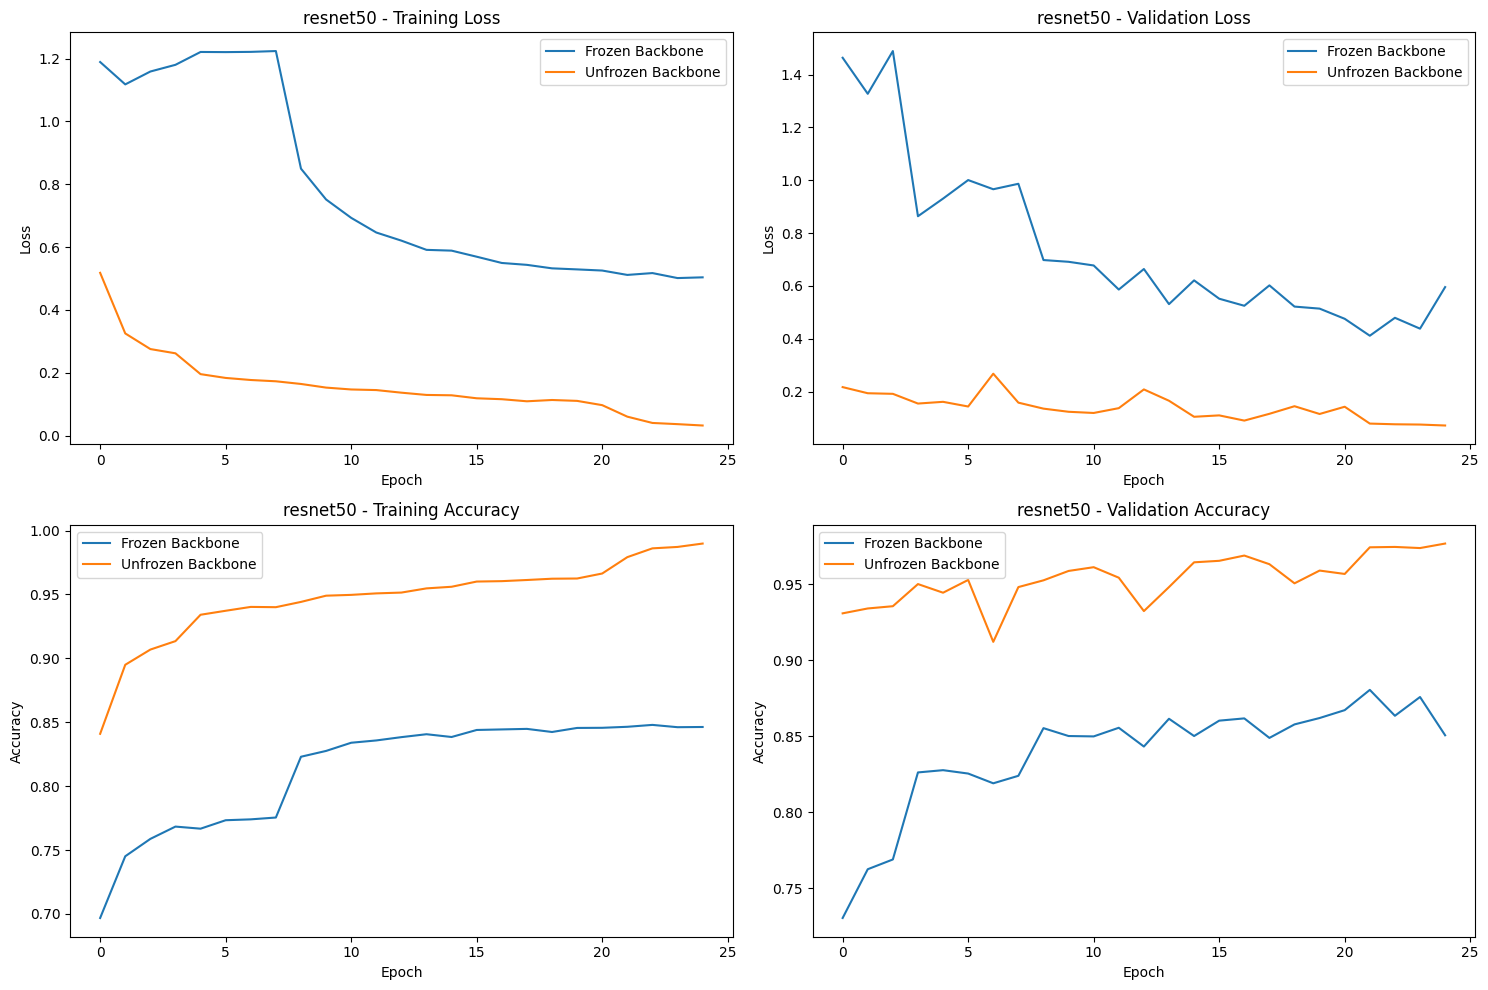

Comparison saved to ../results\resnet50_comparison.json


In [24]:
# Run the main function
if __name__ == "__main__":
    main()